# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=2000)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=2000)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

761

In [3]:
# check the json struckture
url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + weather_api_key
city_url = url+"&q="+"dallas"
city_weather = requests.get(city_url).json()
city_weather

{'coord': {'lon': -96.7836, 'lat': 32.7668},
 'weather': [{'id': 801,
   'main': 'Clouds',
   'description': 'few clouds',
   'icon': '02d'}],
 'base': 'stations',
 'main': {'temp': 83.03,
  'feels_like': 81.25,
  'temp_min': 79.79,
  'temp_max': 85.48,
  'pressure': 1012,
  'humidity': 30},
 'visibility': 10000,
 'wind': {'speed': 14.97, 'deg': 360, 'gust': 25.32},
 'clouds': {'all': 20},
 'dt': 1651349816,
 'sys': {'type': 2,
  'id': 2036480,
  'country': 'US',
  'sunrise': 1651318848,
  'sunset': 1651367260},
 'timezone': -18000,
 'id': 4684904,
 'name': 'Dallas',
 'cod': 200}

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + weather_api_key

city_data = []

print("Beginning Data Retrieval     ")
print("-----------------------------")

for i , city in enumerate(cities):
    
    city_url = url+"&q="+city
    #print(f"Record {i}: Processing {city}.")

    try:
        city_weather = requests.get(city_url).json()
                
        city_lat = city_weather["coord"]["lat"]
        city_lng = city_weather["coord"]["lon"]
        city_max_temp = city_weather["main"]["temp_max"]
        city_humidity = city_weather["main"]["humidity"]
        city_clouds = city_weather["clouds"]["all"]
        city_wind = city_weather["wind"]["speed"]
        city_country = city_weather["sys"]["country"]
        city_date = city_weather["dt"]        
        
        city_data.append({"City": city, 
                          "Lat": city_lat, 
                          "Lng": city_lng, 
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})        
        
    except:
        #print(f"Record {i}: City not found. Skipping...")
        pass
              
# Indicate that Data Loading is complete 
#print("-----------------------------")
print("Data Retrieval Complete      ")    
    

Beginning Data Retrieval     
-----------------------------
Data Retrieval Complete      


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
city_data_pd = pd.DataFrame(city_data)
city_data_pd.head(5)

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,luzon,6.5190,126.0941,79.02,84,97,7.23,PH,1651349981
1,mataura,-46.1927,168.8643,64.47,86,100,3.80,NZ,1651349981
2,takaka,-40.8500,172.8000,60.57,89,54,4.99,NZ,1651349982
3,torbay,47.6666,-52.7314,44.76,96,100,4.61,CA,1651349982
4,saint-francois,46.4154,3.9054,49.68,71,0,8.05,FR,1651349983


In [6]:
city_data_pd.count()

City          699
Lat           699
Lng           699
Max Temp      699
Humidity      699
Cloudiness    699
Wind Speed    699
Country       699
Date          699
dtype: int64

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
city_data_pd.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,6.990000e+02
mean,21.362738,17.890034,61.851760,68.866953,57.944206,7.806466,1.651350e+09
std,32.351073,89.397848,19.901667,22.315741,40.178699,5.014188,1.072130e+02
min,-54.800000,-175.200000,1.870000,8.000000,0.000000,0.000000,1.651350e+09
25%,-5.894300,-63.832000,49.595000,57.500000,12.500000,3.980000,1.651350e+09
50%,26.729200,20.654700,64.360000,74.000000,73.000000,6.910000,1.651350e+09
75%,47.835500,94.950000,79.565000,85.500000,100.000000,10.470000,1.651350e+09
max,78.218600,179.316700,98.580000,100.000000,100.000000,35.680000,1.651350e+09


In [8]:
#  Get the indices of cities that have humidity over 100%.
dirty_city_data = city_data_pd[(city_data_pd["Humidity"] > 100)].index
              
dirty_city_data

Int64Index([], dtype='int64')

In [9]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = city_data_pd.drop(dirty_city_data, inplace=False)
clean_city_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,luzon,6.5190,126.0941,79.02,84,97,7.23,PH,1651349981
1,mataura,-46.1927,168.8643,64.47,86,100,3.80,NZ,1651349981
2,takaka,-40.8500,172.8000,60.57,89,54,4.99,NZ,1651349982
3,torbay,47.6666,-52.7314,44.76,96,100,4.61,CA,1651349982
4,saint-francois,46.4154,3.9054,49.68,71,0,8.05,FR,1651349983


In [10]:
lats = clean_city_data["Lat"]
max_temps = clean_city_data["Max Temp"]
humidity = clean_city_data["Humidity"]
cloudiness = clean_city_data["Cloudiness"]
wind_speed = clean_city_data["Wind Speed"]

In [11]:
lats

0       6.5190
1     -46.1927
2     -40.8500
3      47.6666
4      46.4154
        ...   
694    34.6182
695    42.7834
696    47.8667
697    58.9650
698    38.8876
Name: Lat, Length: 699, dtype: float64

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

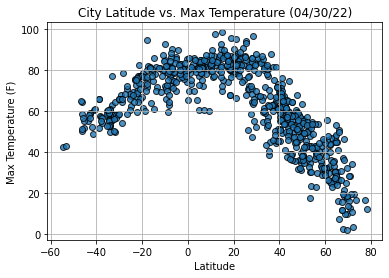

In [12]:
# Build scatter plot for latitude vs. temperature
plt.scatter(lats, 
            max_temps,
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Cities")

# Incorporate the other graph properties
plt.title("City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.ylabel("Max Temperature (F)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Fig1.png")

# Show plot
plt.show()

## Latitude vs. Humidity Plot

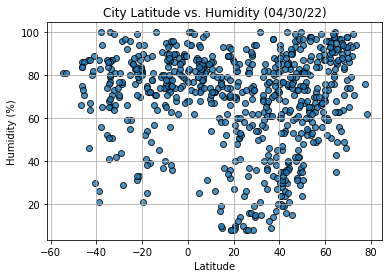

In [13]:
# Build the scatter plots for latitude vs. humidity
plt.scatter(lats, 
            humidity,
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Cities")

# Incorporate the other graph properties
plt.title("City Latitude vs. Humidity (%s)" % time.strftime("%x"))
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Fig2.png")

# Show plot
plt.show()

## Latitude vs. Cloudiness Plot

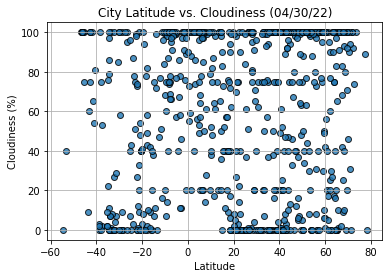

In [14]:
# Build the scatter plots for latitude vs. cloudiness
plt.scatter(lats, 
            cloudiness,
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Cities")

# Incorporate the other graph properties
plt.title("City Latitude vs. Cloudiness (%s)" % time.strftime("%x"))
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Fig3.png")

# Show plot
plt.show()

## Latitude vs. Wind Speed Plot

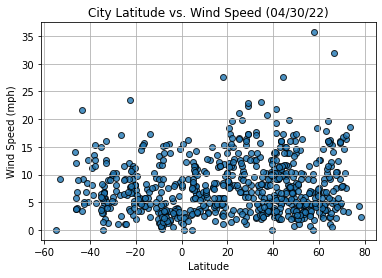

In [15]:
# Build the scatter plots for latitude vs. wind speed
plt.scatter(lats, 
            wind_speed,
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Cities")

# Incorporate the other graph properties
plt.title("City Latitude vs. Wind Speed (%s)" % time.strftime("%x"))
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Fig4.png")

# Show plot
plt.show()

## Linear Regression

In [16]:
# Create a function to create Linear Regression plots
def plot_linear_regression(x_values, y_values, title, text_coordinates):
    
    # Run regresson on southern hemisphere
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Plot
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,text_coordinates,fontsize=15,color="red")
    plt.xlabel('Latitude')
    plt.ylabel(title)
    print(f"The r-value is: {rvalue**2}")
    plt.show()

In [17]:
northern_hemi_df = city_data_pd.loc[(city_data_pd["Lat"] >= 0)]
southern_hemi_df = city_data_pd.loc[(city_data_pd["Lat"] < 0)]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.7484294892780525


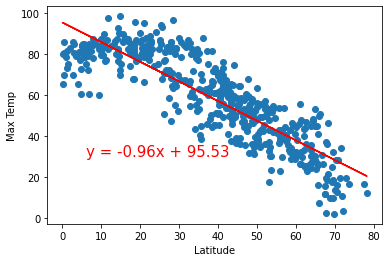

In [18]:
# Linear regression on Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Max Temp"]
plot_linear_regression(x_values, y_values, 'Max Temp',(6,30))

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.6551356919434128


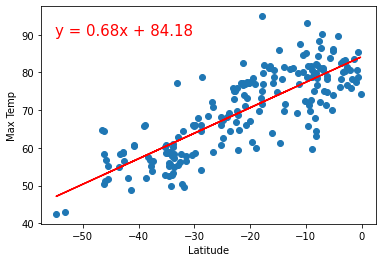

In [19]:
# Linear regression on Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Max Temp"]
plot_linear_regression(x_values, y_values, 'Max Temp', (-55, 90))

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.012385554930071891


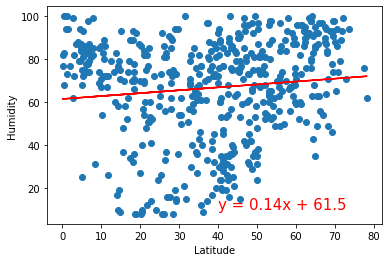

In [20]:
# Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Humidity"]
plot_linear_regression(x_values, y_values, 'Humidity',(40,10))

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.008843449691704131


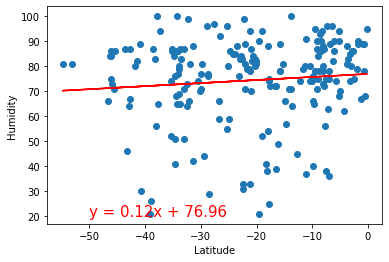

In [21]:
# Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Humidity"]
plot_linear_regression(x_values, y_values, 'Humidity', (-50, 20))

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 3.290142095965178e-06


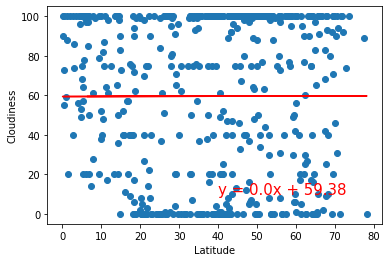

In [22]:
# Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Cloudiness"]
plot_linear_regression(x_values, y_values, 'Cloudiness', (40,10))

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.06516795422129383


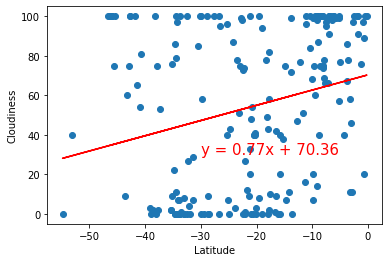

In [23]:
# Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Cloudiness"]
plot_linear_regression(x_values, y_values, 'Cloudiness', (-30,30))

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.00011191854707326144


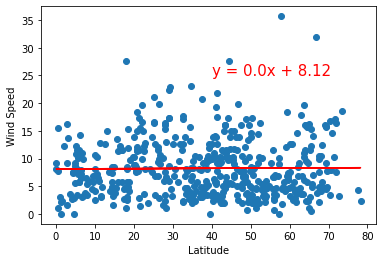

In [24]:
# Northern Hemisphere
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Wind Speed"]
plot_linear_regression(x_values, y_values, 'Wind Speed', (40,25))

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.03138062764716604


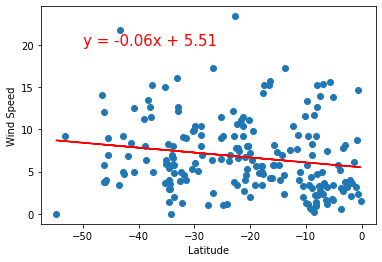

In [25]:
# Southern Hemisphere
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Wind Speed"]
plot_linear_regression(x_values, y_values, 'Wind Speed', (-50, 20))

# VacationPy
----

#### Note
* Keep an eye on your API usage. Use https://developers.google.com/maps/reporting/gmp-reporting as reference for how to monitor your usage and billing.

* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [26]:
import gmaps
import os

from api_keys import g_key


### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [27]:
city_data_df = clean_city_data.copy()
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,luzon,6.5190,126.0941,79.02,84,97,7.23,PH,1651349981
1,mataura,-46.1927,168.8643,64.47,86,100,3.80,NZ,1651349981
2,takaka,-40.8500,172.8000,60.57,89,54,4.99,NZ,1651349982
3,torbay,47.6666,-52.7314,44.76,96,100,4.61,CA,1651349982
4,saint-francois,46.4154,3.9054,49.68,71,0,8.05,FR,1651349983


### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [28]:
gmaps.configure(api_key=g_key)

locations = city_data_df[["Lat", "Lng"]]
humidity = city_data_df["Humidity"]
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=humidity, dissipating=False, max_intensity=300, point_radius=5)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [29]:
narrowed_city_df = city_data_df.loc[(city_data_df["Max Temp"] < 80) & (city_data_df["Max Temp"] > 70) 
                                    & (city_data_df["Wind Speed"] < 10) & (city_data_df["Cloudiness"] == 0)].dropna()
narrowed_city_df

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
89,riyadh,24.6877,46.7219,75.34,24,0,7.61,SA,1651349720
112,koumac,-20.5667,164.2833,73.31,84,0,5.30,NC,1651350027
139,vallenar,-28.5708,-70.7581,78.84,29,0,7.00,CL,1651350038
322,quelimane,-17.8786,36.8883,75.15,88,0,3.44,MZ,1651350113
335,gallup,35.5281,-108.7426,70.56,12,0,5.01,US,1651350119
477,mahajanga,-15.7167,46.3167,78.89,78,0,8.21,MG,1651350176
528,voh,-20.9667,164.7000,71.01,87,0,4.00,NC,1651350197
578,manassas,38.7510,-77.4753,71.60,27,0,8.05,US,1651349945
579,tiznit,29.5833,-9.5000,70.02,36,0,4.41,MA,1651350219
625,khorramshahr,30.4397,48.1664,78.76,50,0,6.91,IR,1651350236


### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [30]:
# Create DataFrame called hotel_df to store hotel names along with city, country and coordinates
hotel_df = narrowed_city_df[["City", "Country", "Lat", "Lng"]].copy()
hotel_df["Hotel Name"] = ""
hotel_df

,City,Country,Lat,Lng,Hotel Name
89,riyadh,SA,24.6877,46.7219,
112,koumac,NC,-20.5667,164.2833,
139,vallenar,CL,-28.5708,-70.7581,
322,quelimane,MZ,-17.8786,36.8883,
335,gallup,US,35.5281,-108.7426,
477,mahajanga,MG,-15.7167,46.3167,
528,voh,NC,-20.9667,164.7000,
578,manassas,US,38.7510,-77.4753,
579,tiznit,MA,29.5833,-9.5000,
625,khorramshahr,IR,30.4397,48.1664,


In [31]:
# Set parameters to search for a hotel
params = {
    "radius": 5000,
    "types": "lodging",
    "key": g_key
}

# Iterate through 
for index, row in hotel_df.iterrows():
    # get lat, lng from df
    lat = row["Lat"]
    lng = row["Lng"]
    
    params["location"] = f"{lat},{lng}"
    
    # Use the search term: "Hotel" and our lat/lng
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # make request and print url
    name_address = requests.get(base_url, params=params)
    
    # convert to json
    name_address = name_address.json()
    
    # Grab the first hotel from the results and store the name
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["results"][0]["name"]
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

hotel_df

Missing field/result... skipping.


,City,Country,Lat,Lng,Hotel Name
89,riyadh,SA,24.6877,46.7219,"InterContinental Riyadh, an IHG Hotel"
112,koumac,NC,-20.5667,164.2833,Le Monitel
139,vallenar,CL,-28.5708,-70.7581,Humacao Bed & Breakfast
322,quelimane,MZ,-17.8786,36.8883,Hotel Flamingo
335,gallup,US,35.5281,-108.7426,Quality Inn & Suites Gallup I-40 Exit 20
477,mahajanga,MG,-15.7167,46.3167,Restaurant Greedy Coco Lodge Majunga
528,voh,NC,-20.9667,164.7000,Le gîte du Koniambo
578,manassas,US,38.7510,-77.4753,Olde Towne Inn
579,tiznit,MA,29.5833,-9.5000,
625,khorramshahr,IR,30.4397,48.1664,دفتر نمایندگی شرکت بازاریابان ایرانیان زمینBIZ


In [32]:
# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["Lat", "Lng"]]

In [33]:
# Add marker layer ontop of heat map
marker_layer = gmaps.marker_layer(locations, info_box_content=hotel_info)
fig.add_layer(marker_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))